# Classification. Linear models and KNN

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures

## Part 1: Implementing Logistic Regression

In this task you need to implement Logistic Regression with l2 regularization using gradient descent algorithm.

Logistic Regression loss:
$$ L(w) = \dfrac{1}{N}\sum_{i=1}^N \log(1 + e^{-\langle w, x_i \rangle y_i}) + \frac{1}{2C} \lVert w \rVert^2  \to \min_w$$
$$\langle w, x_i \rangle = \sum_{j=1}^n w_{j}x_{ij} + w_{0},$$ $$ y_{i} \in \{-1, 1\}$$ where $n$ is the number of features and $N$ is the number of samples.

Gradient descent step:
$$w^{(t+1)} := w^{(t)} + \dfrac{\eta}{N}\sum_{i=1}^N y_ix_i \Big(1 - \dfrac{1}{1 + exp(-\langle w^{(t)}, x_i \rangle y_i)}\Big) - \eta \frac{1}{C} w,$$
where $\eta$ is the learning rate.

**(2 points)** Implement the algorithm and use it to classify the digits (https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) into "even" and "odd" categories. "Even" and "Odd" classes  should correspond to {-1, 1} labels.

Stopping criteria: either the number of iterations exceeds *max_iter* or $||w^{(t+1)} - w^{(t)}||_2 < tol$.

In [3]:
from sklearn.exceptions import NotFittedError

In [545]:
class CustomLogisticRegression:
    _estimator_type = "classifier"
    
    def __init__(self, eta=0.001, max_iter=1000, C=1.0, tol=1e-5, random_state=42, zero_init=False):
        """Logistic Regression classifier.
        
        Args:
            eta: float, default=0.001
                Learning rate.
            max_iter: int, default=1000
                Maximum number of iterations taken for the solvers to converge.
            C: float, default=1.0
                Inverse of regularization strength; must be a positive float.
                Smaller values specify stronger regularization.
            tol: float, default=1e-5
                Tolerance for stopping criteria.
            random_state: int, default=42
                Random state.
            zero_init: bool, default=False
                Zero weight initialization.
        """
        self.eta = eta
        self.max_iter = max_iter
        self.C = C
        self.tol = tol
        self.random_state = np.random.RandomState(seed=random_state)
        self.zero_init = zero_init
        self.loss_array = []
         
    def get_sigmoid(self, X, weights):
        """Compute the sigmoid value."""           
        sig_val = []
        i = 0
        while i < (X.shape[0]):
            sig_val.append(1 / (1 + math.exp(-np.dot(X[i,:],weights))))
            i = i + 1
        return np.array(sig_val)
        
    
    
#     def get_loss(self, x, weights, y):
    def get_loss(self, X, weights, y):
        """Calculate the loss."""
        
        N = X.shape[0]        
        w = np.zeros(shape=(N,1))
        for i in range(N):
            val = 1 + math.exp(-np.multiply(np.dot(weights, X[i,:]),y[i]))
            w[i] = math.log(val)
            
        loss = w.sum() / N + np.linalg.norm(weights)**2/(2*self.C);
#         print(f'loss: {loss}')
        return loss

 
    def get_delta(self, X, weights, y):
        N = X.shape[0]
        n = X.shape[1]

        w = np.zeros(shape=(N,n))
        for i in range(N):
            val = 1 - 1/(1 + math.exp(-np.multiply(np.dot(weights, X[i,:]),y[i])))
            w[i,:] = X[i,:]*y[i]*val
            
        delta = w.sum(axis = 0)/ N * self.eta - weights/self.C*self.eta;
        return delta
    
    
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X]) # a constant feature is included to handle intercept
        self.loss_array = []
        
        num_features = X_ext.shape[1]
        if self.zero_init:
            self.weights_ = np.zeros(num_features) 
        else:
            weight_threshold = 1.0 / (2 * num_features)
            self.weights_ = self.random_state.uniform(low=-weight_threshold,
                                                      high=weight_threshold, size=num_features) # random weight initialization
            
        for i in range(self.max_iter):
#             delta = "<your code>"

            delta = self.get_delta(X_ext, self.weights_, y)
            self.weights_ += delta
        
            loss = self.get_loss(X_ext, self.weights_, y)
            loss_array = self.loss_array.append(loss)
            
            if np.linalg.norm(delta) < self.tol: 
                break
                
#         print(f'result weights: {self.weights_}')
#         print(f'loss array: {self.loss_array}')
        
     
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing positive class probabilities.
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X])
        if hasattr(self, 'weights_'):
            return self.get_sigmoid(X_ext, self.weights_)
        else: 
            raise NotFittedError("CustomLogisticRegression instance is not fitted yet")
    
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        return [1 if v > 0.5 else -1 for v in self.predict_proba(X)]

        

In [29]:
from sklearn import datasets
from sklearn import metrics

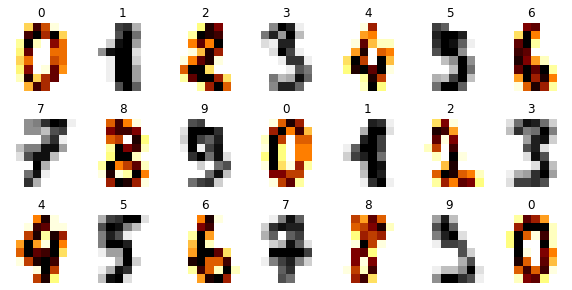

In [1224]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
y_train = (y_train % 2) * 2 - 1
y_test = (y_test % 2) * 2 - 1

array([[ 0.,  0.,  3., ..., 13.,  4.,  0.],
       [ 0.,  0.,  9., ...,  3.,  0.,  0.],
       [ 0.,  0.,  0., ...,  6.,  0.,  0.],
       ...,
       [ 0.,  0.,  9., ..., 16.,  2.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  1.,  0.,  0.]])

In [549]:
assert (np.unique(y_train) == [-1, 1]).all()
assert (np.unique(y_test) == [-1, 1]).all()

In [27]:
def fit_evaluate(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    disp = metrics.plot_confusion_matrix(clf, X_test, y_test, normalize='true')
    disp.figure_.suptitle("Confusion Matrix")
    plt.show()
    
    return metrics.accuracy_score(y_pred=clf.predict(X_train), y_true=y_train), \
           metrics.accuracy_score(y_pred=clf.predict(X_test), y_true=y_test)


def fit_evaluate_without_plot(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    return metrics.accuracy_score(y_pred=clf.predict(X_train), y_true=y_train), \
           metrics.accuracy_score(y_pred=clf.predict(X_test), y_true=y_test)

In [551]:
lr_clf = CustomLogisticRegression(max_iter=1, zero_init=True)

In [552]:
assert np.allclose(lr_clf.get_sigmoid(np.array([[0.5, 0, 1.0], [0.3, 1.3, 1.0]]), np.array([0.5, -0.5, 0.1])),
                   np.array([0.58662, 0.40131]))

In [553]:
lr_clf.fit(X_train, y_train)

In [554]:
assert np.allclose(lr_clf.weights_, np.array([ 3.1000e-06,  0.0000e+00,  4.1800e-05,  5.4770e-04,  2.2130e-04,
        4.8750e-04,  1.3577e-03,  5.9780e-04,  5.6400e-05, -7.0000e-07,
        1.6910e-04,  2.5190e-04, -4.3700e-04,  3.6190e-04,  1.0049e-03,
        4.2280e-04,  2.5700e-05,  3.0000e-07, -1.1500e-05, -7.2440e-04,
       -2.6200e-04,  8.7540e-04,  4.1540e-04, -8.4200e-05, -5.2000e-06,
        0.0000e+00, -2.2160e-04, -5.7130e-04,  9.8570e-04,  1.3507e-03,
        5.0210e-04, -1.7050e-04, -1.0000e-06,  0.0000e+00, -6.7810e-04,
       -1.0515e-03, -4.4500e-05,  3.7160e-04,  4.2100e-04, -8.1800e-05,
        0.0000e+00, -5.2000e-06, -5.3410e-04, -2.0393e-03, -8.4310e-04,
        1.0400e-04, -1.2390e-04, -1.7880e-04, -1.3200e-05, -4.5000e-06,
       -9.4300e-05, -1.1127e-03, -5.0900e-04, -2.1850e-04, -5.6050e-04,
       -3.9560e-04, -1.7700e-05, -3.0000e-07,  2.6800e-05,  6.3920e-04,
        1.8090e-04, -7.3660e-04, -5.3930e-04, -3.7060e-04, -2.8200e-05]), atol=1e-5)

In [555]:
model = CustomLogisticRegression()

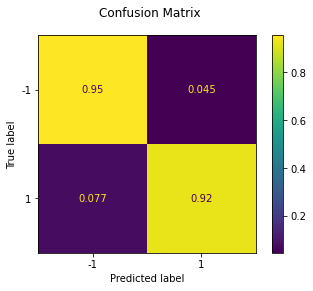

In [556]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [557]:
train_acc, test_acc

(0.9109255393180237, 0.9388888888888889)

In [558]:
assert min(train_acc, test_acc) > 0.9

**(0.5 points)** Visualize the loss history.

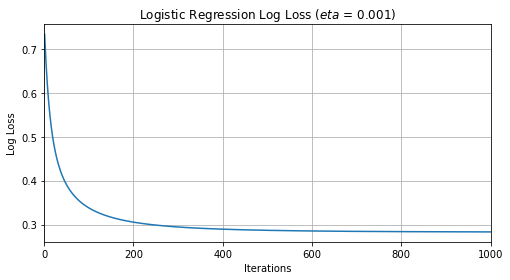

In [575]:
iterations = np.arange(1, len(model.loss_array)+1)

plt.figure(figsize=(8,4))
plt.plot(iterations, model.loss_array)
plt.title('Logistic Regression Log Loss ($eta$ = 0.001)')
plt.xlabel('Iterations')
plt.ylabel('Log Loss')
plt.xlim(0,1000)
plt.grid()
plt.show()

**(0.5 points)** Try different learning rates and compare the results. How does the learning rate influence the convergence?

Для оценки влияния скорости обучения (learning rate) на итоговую точность классификации и сходимость функции потерь (Log Loss) сформируем дополнетельные модели предсказания для `eta = [0.1, 0.01]`.

- Логистическая регрессия с `eta=0.01`.

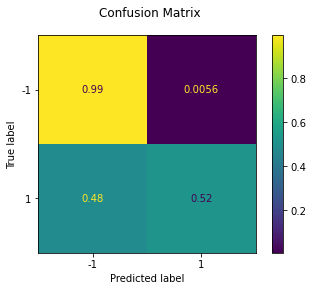

(0.7731384829505915, 0.7527777777777778)

In [560]:
model_01 = CustomLogisticRegression(eta=0.01)
train_acc_01, test_acc_01 = fit_evaluate(model_01, X_train, y_train, X_test, y_test)
train_acc_01, test_acc_01

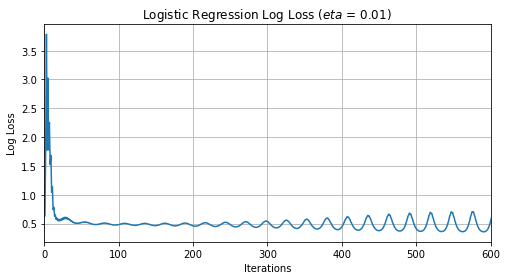

In [579]:
iterations_01 = np.arange(1, len(model_01.loss_array)+1)

plt.figure(figsize=(8,4))
plt.plot(iterations, model_01.loss_array)
plt.title('Logistic Regression Log Loss ($eta$ = 0.01)')
plt.xlabel('Iterations')
plt.ylabel('Log Loss')
plt.grid()
plt.xlim(0,600)
plt.show()

- Логистическая регрессия с `eta=0.1`.

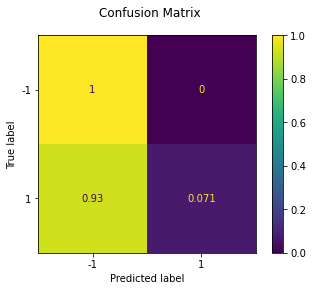

(0.5455810716771051, 0.5277777777777778)

In [561]:
model_1 = CustomLogisticRegression(eta=0.1)
train_acc_1, test_acc_1 = fit_evaluate(model_1, X_train, y_train, X_test, y_test)
train_acc_1, test_acc_1

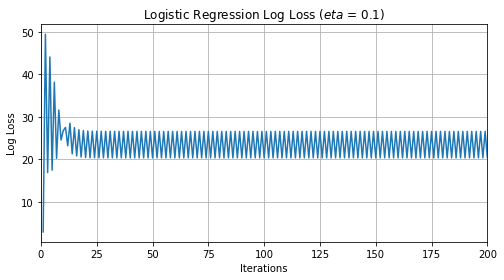

In [572]:
iterations_1 = np.arange(1, len(model_1.loss_array)+1)

plt.figure(figsize=(8,4))
plt.plot(iterations, model_1.loss_array)
plt.title('Logistic Regression Log Loss ($eta$ = 0.1)')
plt.xlabel('Iterations')
plt.ylabel('Log Loss')
plt.grid()
plt.xlim(0,200)
plt.show()

**Выводы:**

- Как следует из графиков выше, с увеличением параметра `eta` ухудшается сходимость ряда функции потерь (Log Loss). Так для `eta=0.001` кривая функции потерь гладкая и монотонно убывающая. Для больших значений `eta` наблюдаются переколебания, но при этом функция быстрее достигает минимального значения.
- Увеличение скорости обучения также снижает точность распознавания, что отображение в таблице ниже.

| eta | tr_acc | test_acc |
|-----|--------|----------|
|0.001| 0.9109 | 0.9388   |
|0.01 | 0.7731 | 0.7527   |
|0.1  | 0.5456 | 0.5278   |

- Скорость сходимости в данном случае разменивается на точность распознавания


**(0.5 points)** Try different regularization parameter values and compare the model quality.

In [596]:
C = [0.5, 0.75, 1, 1.25, 1.5, 2, 3, 4, 5, 10, 50]

train_acc_c = []
test_acc_c = []
for c in C:
    model_СX = CustomLogisticRegression(C=c)
    tr, tst = fit_evaluate_without_plot(model_СX, X_train, y_train, X_test, y_test)
    train_acc_c.append(tr)
    test_acc_c.append(tst)

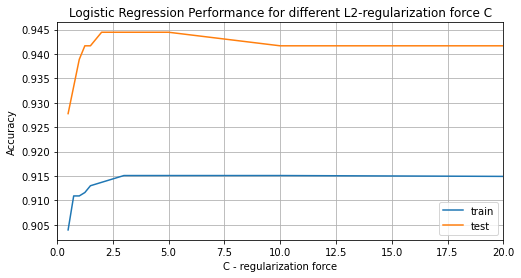

In [597]:
plt.figure(figsize=(8,4))
plt.plot(C, train_acc_c)
plt.plot(C, test_acc_c)
plt.title('Logistic Regression Performance for different L2-regularization force C')
plt.xlabel('C - regularization force')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'])
plt.grid()
plt.xlim(0,20)
plt.show()

In [646]:
df = pd.DataFrame(train_acc_c, index=C, columns = ['train_acc'])
df['test_acc'] = test_acc_c
df.head(20)

,train_acc,test_acc
0.50,0.903967,0.927778
0.75,0.910926,0.933333
1.00,0.910926,0.938889
1.25,0.911621,0.941667
1.50,0.913013,0.941667
2.00,0.913709,0.944444
3.00,0.915101,0.944444
4.00,0.915101,0.944444
5.00,0.915101,0.944444
10.00,0.915101,0.941667


**Выводы**:
- Из графика выше следует, что изменением параметра регуляризации можно добиться определенного увеличения точности классификации в обучающей и тестовой выборке. 
- Кривые точности для обеих выборок имет выраженный пик в диапазоне `C ~= [3,5]`, который и соответствует оптимальным параметрам C. В этом случае достигается максимальная точность распознавания достигает `train_acc= 0.915101` и `test_acc=0.944444`.
- Модель `С<3` является недорегулированной (underfitting), а с `C>5` - перерегулированной (overfitting).

**(0.5 points)** Compare zero initialization and random initialization. 

Сравним точностные характеристики модели с нулевыми начальными значениями и моделями со случайными начальными значениями. При этом модель со случайными весами запустим 2 раза.

- запуск №1 обучения модели со случайными начальными весами.

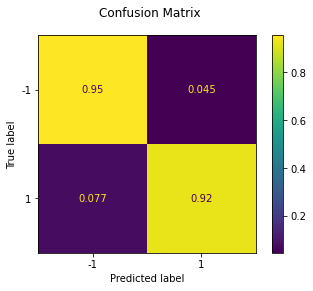

(0.9109255393180237, 0.9388888888888889)

In [648]:
model_rand1 = CustomLogisticRegression(zero_init=False)
train_acc_rand1, test_acc_rand1 = fit_evaluate(model_rand1, X_train, y_train, X_test, y_test)
train_acc_rand1, test_acc_rand1

- запуск №2 обучения модели со случайными начальными весами.

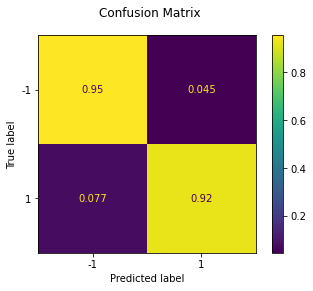

(0.9109255393180237, 0.9388888888888889)

In [653]:
model_rand2 = CustomLogisticRegression(zero_init=False)
train_acc_rand2, test_acc_rand2 = fit_evaluate(model_rand2, X_train, y_train, X_test, y_test)
train_acc_rand2, test_acc_rand2

In [655]:
df = pandas.DataFrame(columns=['train_acc','test_acc'], index=['NoRand','Rand_1','Rand_2'])
df.loc['NoRand'] = pd.Series({'train_acc':train_acc, 'test_acc':test_acc})
df.loc['Rand_1'] = pd.Series({'train_acc':train_acc_rand1, 'test_acc':test_acc_rand1})
df.loc['Rand_2'] = pd.Series({'train_acc':train_acc_rand2, 'test_acc':test_acc_rand2})

df.head()

,train_acc,test_acc
NoRand,0.910926,0.938889
Rand_1,0.910926,0.938889
Rand_2,0.910926,0.938889


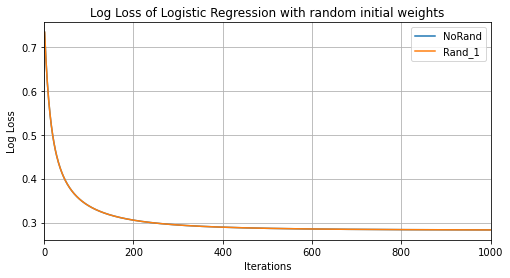

In [664]:
plt.figure(figsize=(8,4))
plt.plot(iterations, model.loss_array)
plt.plot(iterations, model_rand1.loss_array)
plt.title('Log Loss of Logistic Regression with random initial weights')
plt.xlabel('Iterations')
plt.ylabel('Log Loss')
plt.legend(['NoRand', 'Rand_1'])
plt.xlim(0,1000)
plt.grid()
plt.show()

**Выводы**:
- начальные значения весов не имеют решающего значения на сходимость Log Loss и точностные характеристики модели. Функции потерь и значения точности для обозначенных режимов полностью совпадают.
- точностные характеристики модели со случайными начальными весами идентичны от обучения к обучению.

## Part 2: Implementing KNN Classifier

In this task you need to implement weighted K-Neighbors Classifier.

Recall that training a KNN classifier is simply memorizing a training sample. 

The process of applying a classifier for one object is to find the distances from it to all objects in the training data, then select the k nearest objects (neighbors) and return the most common class among these objects.

You can also give the nearest neighbors weights in accordance with the distance of the object to them. In the simplest case (as in your assignment), you can set the weights inversely proportional to that distance. 

$$w_{i} = \frac{1}{d_{i} + eps},$$

where $d_{i}$ is the distance between object and i-th nearest neighbor and $eps$ is the small value to prevent division by zero.

In case of 'uniform' weights, all k nearest neighbors are equivalent (have equal weight, for example $w_{i} = 1, \forall i \in(1,k)$).

To predict the probability of classes, it is necessary to normalize the weights of each class, dividing them by the sum:

$$p_{i} = \frac{w_{i}}{\sum_{j=1}^{c}w_{j}},$$

where $p_i$ is probability of i-th class and $c$ is the number of classes.

**(2 points)** Implement the algorithm and use it to classify the digits. By implementing this algorithm, you will be able to classify numbers not only into "even" or "odd", but into their real representation.

In [1001]:
class CustomKNeighborsClassifier:
    _estimator_type = "classifier"
    
    def __init__(self, n_neighbors=5, weights='uniform', eps=1e-9):
        """K-Nearest Neighbors classifier.
        
        Args:
            n_neighbors: int, default=5
                Number of neighbors to use by default for :meth:`kneighbors` queries.
            weights : {'uniform', 'distance'} or callable, default='uniform'
                Weight function used in prediction.  Possible values:
                - 'uniform' : uniform weights.  All points in each neighborhood
                  are weighted equally.
                - 'distance' : weight points by the inverse of their distance.
                  in this case, closer neighbors of a query point will have a
                  greater influence than neighbors which are further away.
            eps : float, default=1e-5
                Epsilon to prevent division by 0 
        """
        self.n_neighbors = n_neighbors
        self.weights = weights
        self.eps = eps
        
    
    def get_pairwise_distances(self, X, Y):
        """
        Returnes matrix of the pairwise distances between the rows from both X and Y.
        Args:
            X: numpy array of shape (n_samples, n_features)
            Y: numpy array of shape (k_samples, n_features)
        Returns:
            P: numpy array of shape (n_samples, k_samples)
                Matrix in which (i, j) value is the distance 
                between i'th row from the X and j'th row from the Y.
        """
        if X.shape[1] != Y.shape[1]:
            raise Exception("Number of features in X and Y must be the same!") 
        
        n = X.shape[0]
        k = Y.shape[0]
        
        distances = np.zeros(shape=(n,k))
        for i in range(n):
            for j in range(k):
                
                distances[i,j] = np.linalg.norm(X[i,:] - Y[j,:])
                
#         print(distances)        
        return distances
    
    def get_class_weights(self, y, weights):
        """
        Returns a vector with sum of weights for each class 
        Args:
            y: numpy array of shape (n_samles,)
            weights: numpy array of shape (n_samples,)
                The weights of the corresponding points of y.
        Returns:
            p: numpy array of shape (n_classes)
                Array where the value at the i-th position 
                corresponds to the weight of the i-th class.
        """
        if len(y) != len(weights):
            raise Exception("Number of elements in 'y' and 'weights' must be the same!") 
        
        n = len(self.classes_)
        class_weights = np.zeros(n)
        for i in range(n):
            class_weights[i] = weights[np.array(y == self.classes_[i])].sum()

        return class_weights            
        
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        self.points = X
        self.y = y
        self.classes_ = np.unique(y)
        
        
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples, n_classes)
                Vector containing positive class probabilities.
        """
        if hasattr(self, 'points'):
            
            P = self.get_pairwise_distances(X, self.points)
            weights_of_points = np.ones(P.shape)
            if self.weights == 'distance':
                weights_of_points = 1/(P + eps)
            
            c = len(self.classes_)
            m = X.shape[0]
            M = np.zeros(shape=(m,c))
            for i in range(m):
                zipped = zip(P[i,:], self.y, weights_of_points[i,:])
                zip_sorted = sorted(zipped, key=lambda x: x[0])[:self.n_neighbors]
                y1 = np.array([z[1] for z in zip_sorted])
                w1 = np.array([z[2] for z in zip_sorted])
                _w = self.get_class_weights(y1,w1)
                prob = list(_w/_w.sum())
                M[i,:] = prob
                
            return M
        
        else: 
            raise NotFittedError("CustomKNeighborsClassifier instance is not fitted yet")
    
        
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        
        probs = self.predict_proba(X)
        return [self.classes_[arg] for arg in np.argmax(probs, axis=1)]

In [1002]:
model = CustomKNeighborsClassifier(n_neighbors=5, weights='distance')
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')

In [1003]:
assert np.allclose(model.get_pairwise_distances(np.array([[0  , 1]  , [1, 1]]), 
                                                np.array([[0.5, 0.5], [1, 0]])),
                   np.array([[0.70710678, 1.41421356],
                             [0.70710678, 1.        ]]))

In [992]:
model.classes_ = ['one', 'two', 'three']
assert np.allclose(model.get_class_weights(np.array(['one', 'one', 'three', 'two']), np.array([1, 1, 0, 4])), 
                   np.array([2,4,0]))

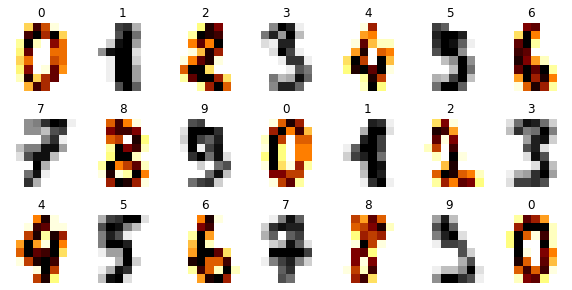

In [993]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [994]:
model.fit(X_train, y_train)
knn.fit(X_train, list(map(str, y_train)));

In [998]:
assert np.allclose(model.predict_proba(X_test), knn.predict_proba(X_test))

probs.shape: (360, 10)
args: [1 1 0 1]
classes_: [0 1 2 3 4 5 6 7 8 9]


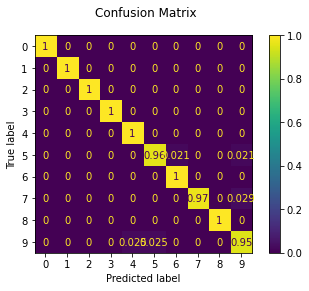

probs.shape: (1437, 10)
args: [1 1 0 1]
classes_: [0 1 2 3 4 5 6 7 8 9]
probs.shape: (360, 10)
args: [1 1 0 1]
classes_: [0 1 2 3 4 5 6 7 8 9]


In [999]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [1000]:
assert train_acc == 1
assert test_acc > 0.98

**(0.5 points)** Take a look at the confusion matrix and tell what numbers the model confuses and why this happens.

Проблемы в распознавании тех или иных символов связаны со схожестью их написания, например:
- **5** : 6, 9
- **7** : 9
- **9** : 4, 5

В приведенном примере проблемными являются символы 5, 7, 9.

**(0.5 points)** Try different n_neighbors parameters and compare the output probabilities of the model.

Определим точностные характеристики моделей при `n_neighbors=[1,10]` и выберем оптимальное значение параметра.

In [1012]:
n_neigh = np.arange(1,11)

train_acc_k = []
test_acc_k = []
for n_i in n_neigh:
    model_KK = CustomKNeighborsClassifier(n_neighbors=n_i, weights='distance')
    tr, tst = fit_evaluate_without_plot(model_KK, X_train, y_train, X_test, y_test)
    train_acc_k.append(tr)
    test_acc_k.append(tst)

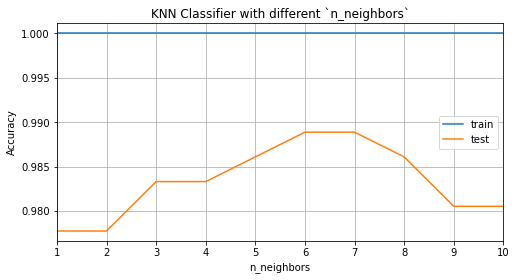

In [1014]:
plt.figure(figsize=(8,4))
plt.plot(n_neigh, train_acc_k)
plt.plot(n_neigh, test_acc_k)
plt.title('KNN Classifier with different `n_neighbors`')
plt.xlabel('n_neighbors')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'])
plt.grid()
plt.xlim(1,10)
plt.show()

In [1016]:
df = pd.DataFrame(train_acc_k, index=n_neigh, columns = ['train_acc'])
df['test_acc'] = test_acc_k
df.head(10)

,train_acc,test_acc
1,1.0,0.977778
2,1.0,0.977778
3,1.0,0.983333
4,1.0,0.983333
5,1.0,0.986111
6,1.0,0.988889
7,1.0,0.988889
8,1.0,0.986111
9,1.0,0.980556
10,1.0,0.980556


**Выводы**:
- Из графика выше следует, что изменением числа ближайших соседей `n_neighbors` можно добиться определенного увеличения точности классификации в обучающей и тестовой выборке. 
- Кривая точности распознавания для обучающей выборки неизменна на уровне 1.0, что объясняется принципом обучения (fit) модели, когда никакие манипуляции на обучающей выборкой не проводятся.
- Кривая точности распознавания для тестовой выборки имеет выражжены пик в диапазоне `n_neighbors = [6,7]`, который и соответствует оптимальным параметрам `n_neighbors`. В этом случае достигается максимальная точность распознавания `test_acc=0.988889`.
- Классификатор при `n_neighbors < 6` более чувствителен к выбросам в данных, а при `n_neighbors > 7` - более интегрирующий и поэтом менее чувстсвителен к особенностям данных.

**(0.5 points)** Compare both 'uniform' and 'distance' weights and share your thoughts in what situations which parameter can be better.

Построим модель KNN (uniform), рассчитаем параметры точности и сравним с KNN (distance).

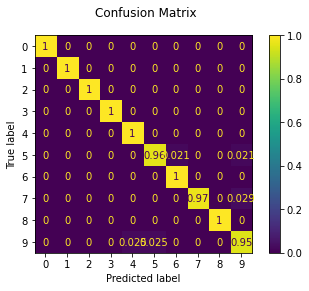

In [1017]:
model_U = CustomKNeighborsClassifier(n_neighbors=5, weights='uniform')
train_acc_U, test_acc_U = fit_evaluate(model_U, X_train, y_train, X_test, y_test)

In [1019]:
df = pandas.DataFrame(columns=['train_acc','test_acc'], index=['distance','uniform'])
df.loc['distance'] = pd.Series({'train_acc':train_acc, 'test_acc':test_acc})
df.loc['uniform'] = pd.Series({'train_acc':train_acc_U, 'test_acc':test_acc_U})

df.head()

,train_acc,test_acc
distance,1.0,0.986111
uniform,0.989562,0.986111


Как следует из таблица, точность распознавния в тестовой выборки у выбранных моделей идентичная, а отличия наблюдаются в точности распознавания обучающей выборки.

Проведем дополнительное исследование. Оценим влияние параметра `n_neigbors` на точностные характеристики KNN (uniform). Для этого будем изменять параметр `n_neigbors` в диапазоне `[1,10]`.

In [1026]:
n_neigh = np.arange(1,11)

train_acc_kU = []
test_acc_kU = []
for n_i in n_neigh:
    model_KKU = CustomKNeighborsClassifier(n_neighbors=n_i, weights='uniform')
    tr, tst = fit_evaluate_without_plot(model_KKU, X_train, y_train, X_test, y_test)
    train_acc_kU.append(tr)
    test_acc_kU.append(tst)

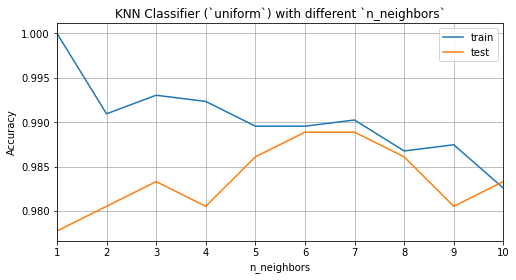

In [1028]:
plt.figure(figsize=(8,4))
plt.plot(n_neigh, train_acc_kU)
plt.plot(n_neigh, test_acc_kU)
plt.title('KNN Classifier (`uniform`) with different `n_neighbors`')
plt.xlabel('n_neighbors')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'])
plt.grid()
plt.xlim(1,10)
plt.show()

In [1022]:
df = pd.DataFrame(train_acc_kU, index=n_neigh, columns = ['train_acc'])
df['test_acc'] = test_acc_kU
df.head(10)

,train_acc,test_acc
1,1.000000,0.977778
2,0.990953,0.980556
3,0.993041,0.983333
4,0.992345,0.980556
5,0.989562,0.986111
6,0.989562,0.988889
7,0.990257,0.988889
8,0.986778,0.986111
9,0.987474,0.980556
10,0.982603,0.983333


Сравним точность распознавания тестовой выборки для KNN(distance) и KNN(uniform).

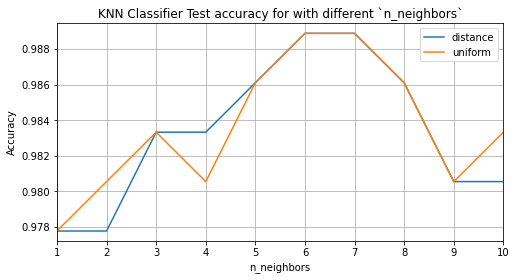

In [1029]:
plt.figure(figsize=(8,4))
plt.plot(n_neigh, test_acc_k)
plt.plot(n_neigh, test_acc_kU)
plt.title('KNN Classifier Test accuracy for with different `n_neighbors`')
plt.xlabel('n_neighbors')
plt.ylabel('Accuracy')
plt.legend(['distance', 'uniform'])
plt.grid()
plt.xlim(1,10)
plt.show()

**Выводы**:
- В отличие от KNN (distance), для текущего классификатора KNN (uniform) удаленность выбранных n объeктов не является решающей, т.к. все выбранные объекты считаются равноудаленными. Такое положение вещей приводит к снижению точности распознавания данных в обучающей выборки. При этом данная точность монотонно убывает от `acc_train=1.0`, соответствующей `n_neighbors=1`, до `acc_train=0.982603`, соответствующей `n_neighbors=10`.
- При этом характер зависимости `acc_train(n_neighbors)` почти полностью соотвествуют аналогичной характеристике классификатора KNN(distance). Данная модель имеет такое же максимальное значение `test_acc=0.988889`.
- При малых значениях `n_neighbors` лучшие результаты должен показывать KNN(distance), т.к. он позволяет различить удаленность выбранных объектов, а при больших значениях `n_neighbors` лучшие результаты должен показать KNN(uniform), т.к. удаленность тех или иных объекто в данном случае играет меньшую роль.

**(0.5 points)** Suggest another distance measurement function that could improve the quality of the classification for this task. 

В данной задаче можно также рассчитывать следующие расстояния между векторами признаков: 
- **COSINE**, чтобы учитывать угол, т.к. все цифры имеют радиальную форму.
- **Chebyshev**, чтобы больше ориентироваться на отличия между векторами (максимальная линейная разность).

**(0.5 points)** Suggest different task and distance function that you think would be suitable for it.

В случае, если нужно было бы классифицировать изображения, основные направления линий на которых были бы параллельны осям координат (и ортогональны друг другу), то оптимальной функцией рассчета расстояния был бы  **Manhattan**, т.к. наборы признаков в таком случае имели бы линейную различимость.

## Part 3: Synthetic Titanic Survival Prediction

### Dataset

Read the description here: https://www.kaggle.com/c/tabular-playground-series-apr-2021/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/tabular-playground-series-apr-2021/overview/evaluation.  


In [3]:
PATH = "./data/"

In [4]:
data = pd.read_csv(os.path.join(PATH, 'titanic', 'train.csv')).set_index('PassengerId')

In [5]:
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S


In [6]:
# data_test = pd.read_csv(os.path.join(PATH, 'titanic', 'test.csv')).set_index('PassengerId')
data_test = pd.read_csv(os.path.join(PATH, 'titanic', 'test.csv'))

In [7]:
data_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,100000,3,"Holliday, Daniel",male,19.0,0,0,24745,63.01,NaN,S
1,100001,3,"Nguyen, Lorraine",female,53.0,0,0,13264,5.81,NaN,S
2,100002,1,"Harris, Heather",female,19.0,0,0,25990,38.91,B15315,C
3,100003,2,"Larsen, Eric",male,25.0,0,0,314011,12.93,NaN,S
4,100004,1,"Cleary, Sarah",female,17.0,0,2,26203,26.89,B22515,C


### EDA

In [8]:
print(f'`data` shape is {data.shape}\n')
data.info()

`data` shape is (100000, 11)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 11 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Survived  100000 non-null  int64  
 1   Pclass    100000 non-null  int64  
 2   Name      100000 non-null  object 
 3   Sex       100000 non-null  object 
 4   Age       96708 non-null   float64
 5   SibSp     100000 non-null  int64  
 6   Parch     100000 non-null  int64  
 7   Ticket    95377 non-null   object 
 8   Fare      99866 non-null   float64
 9   Cabin     32134 non-null   object 
 10  Embarked  99750 non-null   object 
dtypes: float64(2), int64(4), object(5)
memory usage: 9.2+ MB


### Fields definition
- `Survived` - Survival (0 = No; 1 = Yes)
- `Pclass` - Passenger airline class (1 = first, 2 = bussiness, 3 = economy).
- `Name` - Passenger full name (Firts, Second).
- `Sex` - Sex (male, female).
- `Age` - Age (in years).
- `SibSp` - Number of Siblings/Spouses Aboard
- `Parch` - Number of Parents/Children Aboard
- `Ticket` - Ticket number.
- `Fare` - Ticket fare.
- `Cabin` - Cabin (optional).
- `Embarked` - Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

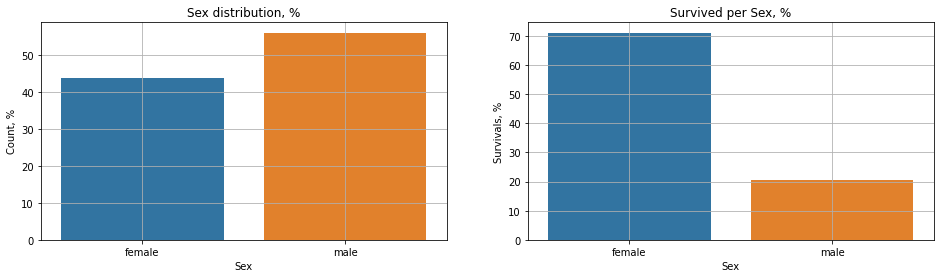

In [9]:
rows_count = data['Sex'].count()
sex_total_count = data.groupby(['Sex']).Name.count()

sex_stats = pd.DataFrame(data = sex_total_count)
sex_stats = sex_stats.rename(columns = {'Name':'Total'})
sex_stats['Total_Percent'] = sex_stats.Total / rows_count * 100
sex_stats['Survived'] = data.loc[data.Survived == True].groupby(['Sex']).Name.count()
sex_stats['Deceased_Percent'] = (sex_total_count - sex_stats.Survived) / sex_total_count * 100
sex_stats['Survived_Percent'] = sex_stats.Survived / sex_total_count * 100
sex_stats['Sex'] = sex_stats.index


fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(16,4))

sns.barplot(x=sex_stats['Sex'], y=sex_stats['Total_Percent'], ax = axes[0])
axes[0].set_title('Sex distribution, %')
axes[0].set_ylabel('Count, %')
axes[0].set_xlabel('Sex')
axes[0].grid()


sns.barplot(x=sex_stats['Sex'], y=sex_stats['Survived_Percent'], ax = axes[1])
axes[1].set_title('Survived per Sex, %')
axes[1].set_ylabel('Survivals, %')
axes[1].set_xlabel('Sex')
axes[1].grid()

In [10]:
sex_stats.head()

,Total,Total_Percent,Survived,Deceased_Percent,Survived_Percent,Sex
Sex,,,,,,
female,43886,43.886,31226,28.847468,71.152532,female
male,56114,56.114,11548,79.420465,20.579535,male


**Выводы:**
- при общем превосходстве числа мужчин на судне (56% мужчин против 44% женщин) выживших среди женщин в 3.5 раза больше (20.5% мужчин против 71% жинщин). Объясняется это тем, что женщин спасали в первую очередь.

**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

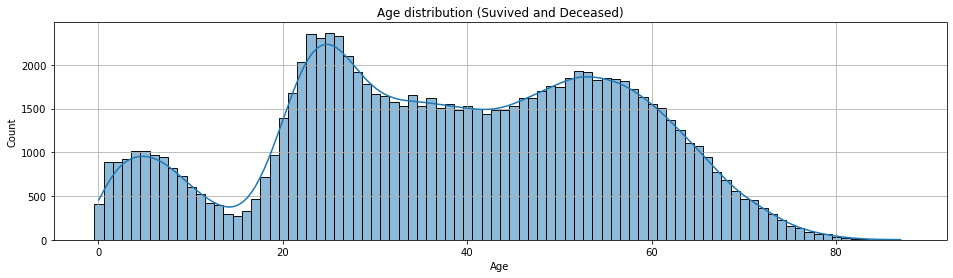

In [11]:
plt.figure(figsize=(16,4))
sns.histplot(data, x="Age", discrete=True, kde=True )
plt.title(f"Age distribution (Suvived and Deceased)")
plt.grid()

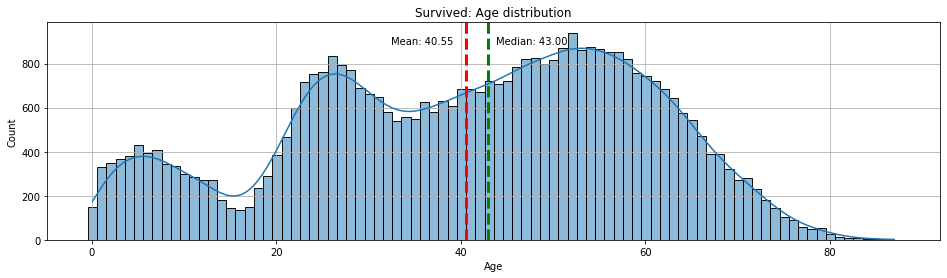

In [12]:
age_survived = data.loc[pd.notna(data.Age)].loc[data.Survived==1]['Age']
age_survived_mean = np.mean(age_survived)
age_survived_median = np.median(age_survived)

age_deceased = data.loc[pd.notna(data.Age)].loc[data.Survived==0]['Age']
age_deceased_mean = np.mean(age_deceased)
age_deceased_median = np.median(age_deceased)

plt.figure(figsize=(16,4))
sns.histplot(data.loc[data.Survived==1,:], x="Age", discrete=True, kde=True )
plt.axvline(age_survived_mean, color='r', linestyle='dashed', linewidth=3)
plt.axvline(age_survived_median, color='g', linestyle='dashed', linewidth=3)
plt.title(f"Survived: Age distribution")

min_ylim, max_ylim = plt.ylim()
plt.text(age_survived_mean*0.8, max_ylim*0.9,'Mean: {:.2f}'.format(age_survived_mean))
plt.text(age_survived_median*1.02, max_ylim*0.9,'Median: {:.2f}'.format(age_survived_median))
plt.grid()

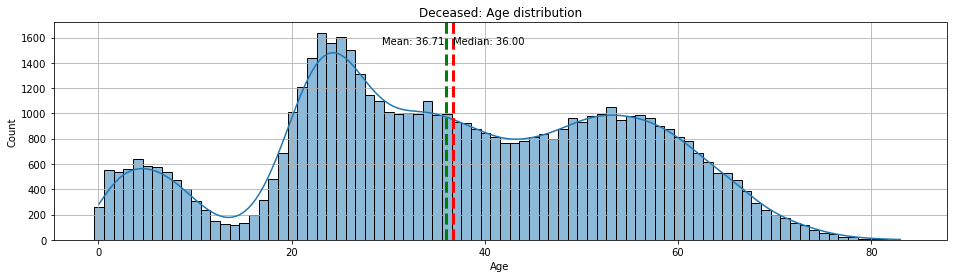

In [13]:
plt.figure(figsize=(16,4))
sns.histplot(data.loc[data.Survived==0,:], x="Age", discrete=True, kde=True )
plt.axvline(age_deceased_mean, color='r', linestyle='dashed', linewidth=3)
plt.axvline(age_deceased_median, color='g', linestyle='dashed', linewidth=3)
plt.title(f"Deceased: Age distribution")

min_ylim, max_ylim = plt.ylim()
plt.text(age_deceased_mean*0.8, max_ylim*0.9,'Mean: {:.2f}'.format(age_deceased_mean))
plt.text(age_deceased_median*1.02, max_ylim*0.9,'Median: {:.2f}'.format(age_deceased_median))
plt.grid()

**Выводы:**
- Из графиков распределения возрастов выживших и погибших следует, что спасали в первую очередь более пожилых людей. Так максимум выжившах людей имели возраст от 50 до 60 лет, в то время как большая часть погибших людей имела возраст от 24 до 30 лет.
- В подтверждение вывода выше: медианное значение возраста выживших составляет 43 года, в то время как медианное значение возраста погибших - 36-37 лет.

**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

#### Passenger class (Pclass) 

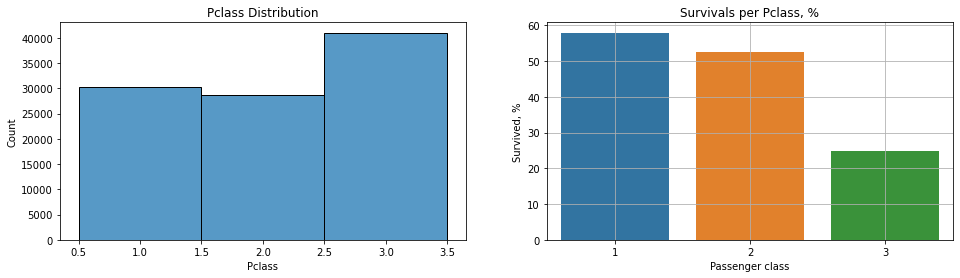

In [14]:
pclass_total_count = data.groupby(['Pclass']).Name.count()

pclass_stats = pd.DataFrame(data = pclass_total_count)
pclass_stats = pclass_stats.rename(columns = {'Name':'Total'})
pclass_stats['Survived'] = data.loc[data.Survived == True].groupby(['Pclass']).Name.count()
pclass_stats['Deceased_Percent'] = (pclass_stats.Total - pclass_stats.Survived) / pclass_stats.Total * 100
pclass_stats['Survived_Percent'] = pclass_stats.Survived / pclass_stats.Total * 100
pclass_stats['Pclass'] = pclass_stats.index

fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(16,4))
sns.histplot(data, x="Pclass", discrete=True, ax = axes[0])
axes[0].set_title(f"Pclass Distribution")

sns.barplot(x=pclass_stats.Pclass, y=pclass_stats.Survived_Percent, ax = axes[1])
axes[1].set_title(f"Survivals per Pclass, %")
axes[1].set_xlabel('Passenger class')
axes[1].set_ylabel('Survived, %')
axes[1].grid()

In [15]:
pclass_stats.head()

,Total,Survived,Deceased_Percent,Survived_Percent,Pclass
Pclass,,,,,
1,30315,17576,42.022101,57.977899,1
2,28679,15057,47.498169,52.501831,2
3,41006,10141,75.269473,24.730527,3


#### Embarkation Port (Embarked)

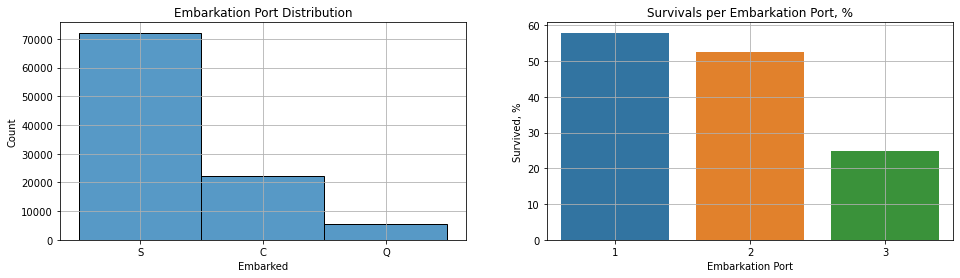

In [16]:
embarked_total_count = data.groupby(['Embarked']).Name.count()

embarked_stats = pd.DataFrame(data = embarked_total_count)
embarked_stats = embarked_stats.rename(columns = {'Name':'Total'})
embarked_stats['Survived'] = data.loc[data.Survived == True].groupby(['Pclass']).Name.count()
embarked_stats['Deceased_Percent'] = (embarked_stats.Total - embarked_stats.Survived) / embarked_stats.Total * 100
embarked_stats['Survived_Percent'] = embarked_stats.Survived / embarked_stats.Total * 100
embarked_stats['Embarked'] = embarked_stats.index


fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(16,4))

sns.histplot(data, x="Embarked", discrete=True, ax = axes[0])
axes[0].set_title(f"Embarkation Port Distribution")
axes[0].grid()

sns.barplot(x=pclass_stats.Pclass, y=pclass_stats.Survived_Percent, ax = axes[1])
axes[1].set_title(f"Survivals per Embarkation Port, %")
axes[1].set_xlabel('Embarkation Port')
axes[1].set_ylabel('Survived, %')
# axes[1].set_xticks(('S','C','Q'))
axes[1].grid()

**Выводы:**
- наибольшее число пассажиров плыла в третьем классе,т.к. он самый дешевый. При этом наиболее безовасным с точки зрения выживания оказался первый класс.
- наибольшее число пассажиров выплыло из Southampton (S), он и оказался самым безопасным.

### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

In [17]:
print("#\tColumn Name \tNull, %")
print("---\t---   \t\t---")
i = 1
for col in data.columns:
    null_percent = data.loc[pd.isna(data[col])][col].shape[0] / data[col].shape[0] * 100
    print(f"{i}\t{col.ljust(15)}\t{null_percent}%")
    i += 1

#	Column Name 	Null, %
---	---   		---
1	Survived       	0.0%
2	Pclass         	0.0%
3	Name           	0.0%
4	Sex            	0.0%
5	Age            	3.292%
6	SibSp          	0.0%
7	Parch          	0.0%
8	Ticket         	4.623%
9	Fare           	0.134%
10	Cabin          	67.866%
11	Embarked       	0.25%


Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages?


В рассматриваемом наборе данных 5 признаков имеют пропущенные значения: Age, Ticket, Fare, Cabin, Embarked.
Можно выделить следующие подходы по работе с признаками с пропущенными значениями:
- полностью не рассматривать такие признаки при обучении модели. Сюда можно отнести признакми с большим числом пропуском, например, Cabin.
- исключить из набора данных строчки, с пропусками в одном из параметров. Данный метод подходит для признаков с малым числом пропусков, например, Age, Ticket, Fare, Embarked.
- заменять пропущенные значения другими. Данный метод подходит для легко интерпретируемых данных, например, для возраста (Age) или цены билетов (Fare).

Все обозначенные подходы имеют несколько недостатков: или объем обучающей и тестовой выборок сокращается, или данные выборки содержат параметры с некорректными значениями.

Для текущей задачи пока не будем учитывать параметр Cabin, а также удалим все строки в DataFrame, содержащих пропущенные значения.

**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

### 1. Prepare dataset

 Подготовим набор данных для обучения.

In [18]:
data.dtypes

Survived      int64
Pclass        int64
Name         object
Sex          object
Age         float64
SibSp         int64
Parch         int64
Ticket       object
Fare        float64
Cabin        object
Embarked     object
dtype: object

In [19]:
def spl_tick(x):
    """Extracting letters from tickets"""
    return x.split()[0] if x.isdigit() == False else '-'

def re_symb(x):
    """Removing symbols"""
    return re.sub(r"[#%!@*.,!:;]", "", x)

def digit_tick(x):
    """Extract digits from tickets"""
    digits = [int(s) for s in x.split() if s.isdigit()]
    return digits[0] if len(digits)>0 else 0

In [20]:
def prepare_dataset(data):
    dataset = data.copy()

    # redundant_columns = ['Name', 'Cabin', 'Ticket']
    redundant_columns = ['Name', 'Cabin']
#     redundant_columns = ['Name']

    cols_to_drop = redundant_columns
    print(f'will drop following columns: {cols_to_drop} .')
    dataset.drop(columns=cols_to_drop, inplace=True)

#     age_medeian = np.median(data.loc[pd.notna(data['Age'])].loc[data.Survived==0]['Age'])
#     fare_medeian = np.median(data.loc[pd.notna(data['Fare'])].loc[data.Survived==0]['Fare'])
#     dataset['Age'] = dataset['Age'].fillna(age_medeian)
#     dataset['Fare'] = dataset['Fare'].fillna(fare_medeian)
    
    dataset['Age'] = dataset['Age'].fillna(0)
    dataset['Fare'] = dataset['Fare'].fillna(0)

    dataset['Ticket'] = dataset['Ticket'].fillna('0')
#     dataset['Cabin'] = dataset['Cabin'].fillna('0')

    return dataset

dataset = prepare_dataset(data)

will drop following columns: ['Name', 'Cabin'] .


In [21]:
print(f'will drop rows with NaN values .')
dataset = dataset.loc[dataset.isna().sum(axis=1)==0]

print(f'Dataset shape: {dataset.shape}')

will drop rows with NaN values .
Dataset shape: (99750, 9)


Изменим формат записи полей Sex, Embarked, Ticket, Cabin на числовой.

In [22]:
def update_dataset(dataset):
    
    dataset['Sex_1'] = [0 if v=='male' else 1 for v in dataset['Sex']]
    dataset['Embarked_1'] = [0 if v=='S' else (1 if v=='C' else 2) for v in dataset['Embarked']]
    dataset['Ticket_type'] = dataset['Ticket'].apply(spl_tick).apply(re_symb)
    dataset['Ticket_1'] = dataset['Ticket'].apply(digit_tick)
#     dataset['Cabin_type'] = dataset['Cabin'].apply(spl_tick).apply(re_symb)
#     dataset['Cabin_1'] = dataset['Cabin'].apply(digit_tick)
    
    dataset['Family'] = dataset['SibSp'] + dataset['Parch']
    
    
    # Convert ticket type to int code.
    unique_tick_types = list(dataset['Ticket_type'].unique())
    tick_type_codes = np.arange(0,len(unique_tick_types))
    tick_type_zip = zip(unique_tick_types, tick_type_codes)
    tick_dict = dict(tick_type_zip)

    def convert_tick_to_int_type(x):
        res = tick_dict.get(x)
        return res if res!= None else 0

    dataset['Ticket_code'] = dataset['Ticket_type'].apply(convert_tick_to_int_type)
    dataset.drop(columns=['Ticket_type'], inplace=True)
    

#     # Convert cabin type to int code.
#     unique_cab_types = list(dataset['Cabin_type'].unique())
#     cab_type_codes = np.arange(0,len(unique_cab_types))
#     cab_type_zip = zip(unique_tick_types, tick_type_codes)

#     cab_dict = dict(cab_type_zip)
#     def convert_cab_to_int_type(x):
#         res = cab_dict.get(x)
#         return res if res!= None else 0

#     dataset['Cabin_code'] = dataset['Cabin_type'].apply(convert_cab_to_int_type)
#     dataset.drop(columns=['Cabin_type'], inplace=True)
    
    # Rename modified columns.
    dataset.drop(columns=['Sex', 'Embarked', 'Ticket'], inplace=True)
#     dataset.drop(columns=['Sex', 'Embarked', 'Ticket', 'Cabin'], inplace=True)

    dataset.rename(columns={'Sex_1': 'Sex'}, inplace=True)
    dataset.rename(columns={'Embarked_1': 'Embarked'}, inplace=True)
    dataset.rename(columns={'Ticket_1': 'Ticket'}, inplace=True)
#     dataset.rename(columns={'Cabin_1': 'Cabin'}, inplace=True)
    
    return dataset

dataset = update_dataset(dataset)
dataset.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex,Embarked,Ticket,Family,Ticket_code
PassengerId,,,,,,,,,,,
0,1,1,0.00,2,0,27.14,0,0,209245,2,0
1,0,3,0.00,0,0,13.35,0,0,27323,0,0
2,0,3,0.33,1,2,71.29,0,0,457703,3,1
3,0,3,19.00,0,0,13.04,0,0,10866,0,2
4,1,3,25.00,0,0,7.76,0,0,427635,0,0


### 2. train/test split

In [23]:
print(dataset.shape)
ix_split = int(0.8 * dataset.shape[0])
DF_TRAIN = dataset.iloc[:ix_split].copy()
DF_TEST = dataset.iloc[ix_split:].copy()
print(DF_TRAIN.shape, DF_TEST.shape)

(99750, 11)
(79800, 11) (19950, 11)


In [24]:
from typing import List, Iterable
def get_train_test_data(features: List[str], target: str) -> tuple:
    """
    Return x_train, y_train, x_test, y_test using 
    * global train/test split 
    * features and target provided.
    """
    # in general, it's a bad practice to use global variables. 
    # however, we use it here with caution for simplicity.
    return (
        DF_TRAIN[features].copy().to_numpy(), DF_TRAIN[target].copy().to_numpy(), 
        DF_TEST[features].copy().to_numpy(), DF_TEST[target].copy().to_numpy()
    )

In [25]:
target = 'Survived'
# features = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex', 'Embarked'] # basic
features = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex', 'Embarked' , 'Ticket', 'Ticket_code'] ## the best
# features = ['Pclass', 'Age', 'Fare', 'Sex', 'Embarked']  #3
# features = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex', 'Embarked' , 'Ticket'] 
# features = ['Pclass', 'Age', 'Fare', 'Sex', 'Embarked' , 'Ticket', 'Ticket_code'] 
# features = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex', 'Embarked' , 'Ticket', 'Ticket_code', 'Cabin', 'Cabin_code'] 
# features = ['Pclass', 'Age', 'Family', 'Fare', 'Sex', 'Embarked' , 'Ticket', 'Ticket_code']


X_train, y_train, X_test, y_test = get_train_test_data(features, target)
X = dataset[features].copy().to_numpy()
y = dataset[target].copy().to_numpy()

# degree = 3
# poly = PolynomialFeatures(degree)
# poly.fit_transform(X)

### 3. Training 

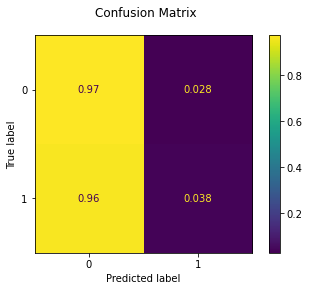

(0.5826741854636591, 0.5829774436090225)

In [30]:
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')

lr = LogisticRegression(random_state=0, max_iter=100)
fit_evaluate(lr, X_train, y_train, X_test, y_test)

results = cross_validate(lr, X, y, cv=5, return_train_score=True)

train_acc = np.mean(results['train_score'])
test_acc = np.mean(results['test_score'])
train_acc, test_acc

- Пробное обучение KNN

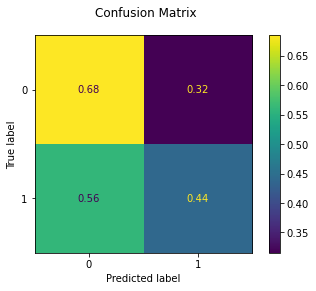

(0.9998045112781954, 0.5784862155388472)

In [31]:
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')
fit_evaluate(knn, X_train, y_train, X_test, y_test)

results = cross_validate(knn, X, y, cv=5, return_train_score=True)

train_acc = np.mean(results['train_score'])
test_acc = np.mean(results['test_score'])
train_acc, test_acc

**Выводы:**
- на выбранных параметрах лучшую точнось распознавания демонстрирует Логистическая Регрессия (`test_acc=0.7583`). Точность для KNN составляет `test_acc=0.7072`.
- для повышения точности распознавания необходимо оптимизировать перечень признаков и параметры моделей.

**(0.5 + X points)** Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression (or both).

Select the best model, load the test set and make the predictions. Submit them to kaggle and see the results :)

**Note**. X points will depend on your kaggle public leaderboard score.
$$ f(score) = 1.0, \ \ 0.79 \leq score < 0.80,$$
$$ f(score) = 2.5, \ \ 0.80 \leq score < 0.81,$$ 
$$ f(score) = 4.0, \ \ 0.81 \leq score $$ 
Your code should generate the output submitted to kaggle. Fix random seeds to make the results reproducible.

### 1. Нормировка данных.

In [32]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X1 = scaler.fit_transform(X)
# X1 = X.copy()
X1_train, X1_test, y_train, y_test = train_test_split(X1, y, test_size=0.2, shuffle=True, random_state=42)

#### Logistic Regression

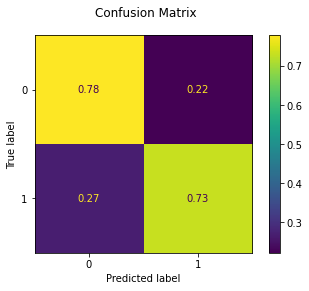

(0.7588345864661654, 0.7578947368421053)

In [33]:
lr = LogisticRegression(random_state=0, max_iter=100)
fit_evaluate(lr, X1_train, y_train, X1_test, y_test)

#### kNN (distance, p=1)

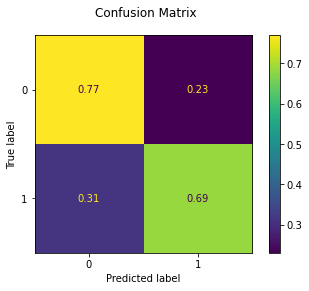

(0.9997994987468671, 0.7343859649122807)

In [34]:
knn = KNeighborsClassifier(n_neighbors=5, weights='distance', p=1)
fit_evaluate(knn, X1_train, y_train, X1_test, y_test)

#### kNN (distance, p=2)

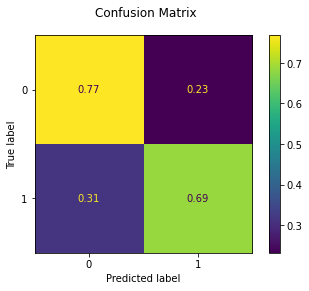

(0.9997994987468671, 0.7324812030075188)

In [35]:
knn = KNeighborsClassifier(n_neighbors=5, weights='distance', p=2)
fit_evaluate(knn, X1_train, y_train, X1_test, y_test)

#### kNN (uniform, p=1)

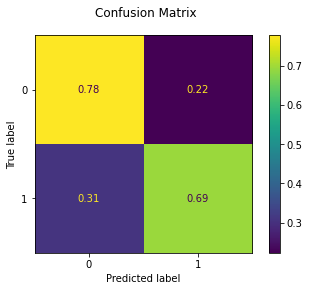

(0.8161027568922306, 0.741904761904762)

In [36]:
knn = KNeighborsClassifier(n_neighbors=5, weights='uniform', p=1)
fit_evaluate(knn, X1_train, y_train, X1_test, y_test)

#### kNN (uniform, p=2)

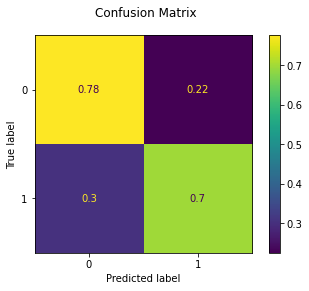

(0.8149624060150376, 0.7418045112781955)

In [37]:
knn = KNeighborsClassifier(n_neighbors=5, weights='uniform', p=2)
fit_evaluate(knn, X1_train, y_train, X1_test, y_test)

### 2. Настройка Logistic Regression

In [38]:
C = [0.5, 0.75, 1., 1.25, 1.5, 2., 3., 4., 5., 6., 7. ,8., 10., 12., 15., 25., 40.,  50., 60., 75., 100., 200., 500., 1000., 1500., 2000., 5000., 10000., 50000.]
# C = [1.,  2.,  10.,  50.]


train_acc_c = []
test_acc_c = []
for c in C:
#     lr = LogisticRegression(C=c, max_iter=1000) #OK!! 
    lr = LogisticRegression(C=c, max_iter=1000, solver='liblinear', penalty='l1') # Ok (try)
#     lr = LogisticRegression(C=c, max_iter=1000, solver='liblinear', penalty='l2') 
#     lr = LogisticRegression(C=c, max_iter=1000, fit_intercept=False)
    results = cross_validate(lr, X1, y, cv=5, return_train_score=True)

    tr = np.mean(results['train_score'])
    tst = np.mean(results['test_score'])
    train_acc_c.append(tr)
    test_acc_c.append(tst)



In [39]:
c_opt = C[np.argmax(test_acc_c)]
test_acc_max = np.max(test_acc_c)
print(f'Optimal C : {c_opt}, test_acc: {test_acc_max}')

Optimal C : 0.5, test_acc: 0.7587869674185463


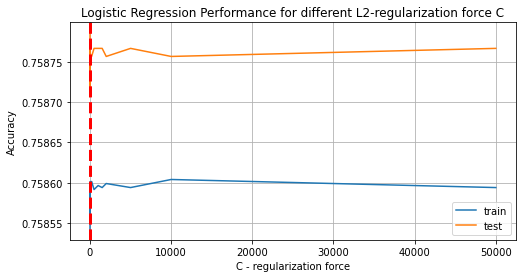

In [40]:
plt.figure(figsize=(8,4))
plt.plot(C, train_acc_c)
plt.plot(C, test_acc_c)
plt.axvline(c_opt, color='r', linestyle='dashed', linewidth=3)
plt.title('Logistic Regression Performance for different L2-regularization force C')
plt.xlabel('C - regularization force')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'])
# plt.xlim(0,200)
# plt.xlim(0,10)
plt.grid()
plt.show()

### 3. Настройка KNN (distance,  p=1|p=2)

In [41]:
n_neigh = [5, 50, 100, 250, 1000]

train_acc_kD1 = []
test_acc_kD1 = []
for n_i in n_neigh:
    knn1 = KNeighborsClassifier(n_neighbors=n_i, weights='distance', p=1)
    tr, tst = fit_evaluate_without_plot(knn1, X1_train, y_train, X1_test, y_test)
    train_acc_kD1.append(tr)
    test_acc_kD1.append(tst)

train_acc_kD2 = []
test_acc_kD2 = []
for n_i in n_neigh:
    knn1 = KNeighborsClassifier(n_neighbors=n_i, weights='distance', p=2)
    tr, tst = fit_evaluate_without_plot(knn1, X1_train, y_train, X1_test, y_test)
    train_acc_kD2.append(tr)
    test_acc_kD2.append(tst)

In [42]:
n_optD1 = n_neigh[np.argmax(test_acc_kD1)]
test_acc_max = np.max(test_acc_kD1)
print(f'Optimal K_neighbors (`distance`, p=1) : {n_optD1}, test_acc: {test_acc_max}')

n_optD2 = n_neigh[np.argmax(test_acc_kD2)]
test_acc_max = np.max(test_acc_kD2)
print(f'Optimal K_neighbors (`distance`, p=2) : {n_optD2}, test_acc: {test_acc_max}')

Optimal K_neighbors (`distance`, p=1) : 250, test_acc: 0.768170426065163
Optimal K_neighbors (`distance`, p=2) : 250, test_acc: 0.7665664160401002


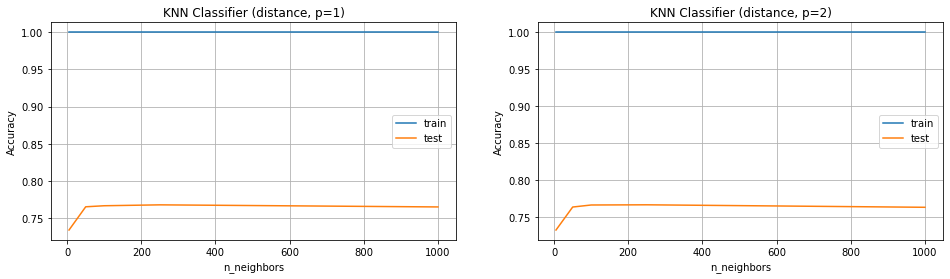

In [43]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(16,4))

axes[0].plot(n_neigh, train_acc_kD1)
axes[0].plot(n_neigh, test_acc_kD1)
axes[0].axvline(n_optD1, color='r', linestyle='dashed', linewidth=3)
axes[0].set_title('KNN Classifier (distance, p=1)')
axes[0].set_xlabel('n_neighbors')
axes[0].set_ylabel('Accuracy')
axes[0].legend(['train', 'test'])
axes[0].grid()

axes[1].plot(n_neigh, train_acc_kD2)
axes[1].plot(n_neigh, test_acc_kD2)
axes[1].axvline(n_optD2, color='r', linestyle='dashed', linewidth=3)
axes[1].set_title('KNN Classifier (distance, p=2)')
axes[1].set_xlabel('n_neighbors')
axes[1].set_ylabel('Accuracy')
axes[1].legend(['train', 'test'])
axes[1].grid()

### 3.2 KNN (uniform, p=1|p=2)

In [44]:
n_neigh = [5, 50, 100, 250, 1000]

train_acc_kU1 = []
test_acc_kU1 = []
for n_i in n_neigh:
    knn1 = KNeighborsClassifier(n_neighbors=n_i, weights='uniform', p=1)
    tr, tst = fit_evaluate_without_plot(knn1, X1_train, y_train, X1_test, y_test)
    train_acc_kU1.append(tr)
    test_acc_kU1.append(tst)

train_acc_kU2 = []
test_acc_kU2 = []
for n_i in n_neigh:
    knn1 = KNeighborsClassifier(n_neighbors=n_i, weights='uniform', p=2)
    tr, tst = fit_evaluate_without_plot(knn1, X1_train, y_train, X1_test, y_test)
    train_acc_kU2.append(tr)
    test_acc_kU2.append(tst)

In [45]:
n_optU1 = n_neigh[np.argmax(test_acc_kU1)]
test_acc_max = np.max(test_acc_kU1)
print(f'Optimal K_neighbors (`uniform`, p=1) : {n_optU1}, test_acc: {test_acc_max}')

n_optU2 = n_neigh[np.argmax(test_acc_kU2)]
test_acc_max = np.max(test_acc_kU2)
print(f'Optimal K_neighbors (`uniform`, p=2) : {n_optU2}, test_acc: {test_acc_max}')

Optimal K_neighbors (`uniform`, p=1) : 100, test_acc: 0.7692731829573934
Optimal K_neighbors (`uniform`, p=2) : 100, test_acc: 0.7685714285714286


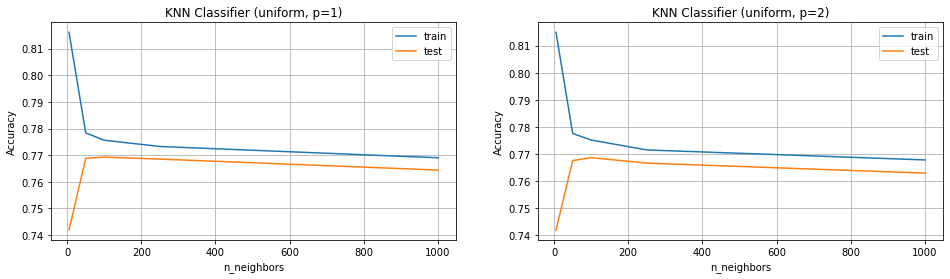

In [46]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(16,4))

axes[0].plot(n_neigh, train_acc_kU1)
axes[0].plot(n_neigh, test_acc_kU1)
axes[0].set_title('KNN Classifier (uniform, p=1)')
axes[0].set_xlabel('n_neighbors')
axes[0].set_ylabel('Accuracy')
axes[0].legend(['train', 'test'])
axes[0].grid()

axes[1].plot(n_neigh, train_acc_kU2)
axes[1].plot(n_neigh, test_acc_kU2)
axes[1].set_title('KNN Classifier (uniform, p=2)')
axes[1].set_xlabel('n_neighbors')
axes[1].set_ylabel('Accuracy')
axes[1].legend(['train', 'test'])
axes[1].grid()

### 4. Результаты настройки Logistic Regression и KNN

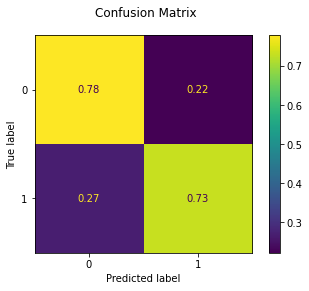

(0.758796992481203, 0.7579949874686717)

In [47]:
# lr_result = LogisticRegression(C=c_opt, max_iter=1000)
lr_result = LogisticRegression(C=c_opt, max_iter=1000, solver='liblinear', penalty='l1') # Ok (try)
fit_evaluate(lr_result, X1_train, y_train, X1_test, y_test)

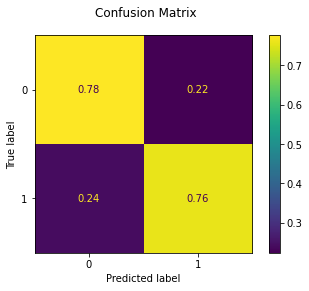

(0.9997994987468671, 0.768170426065163)

In [48]:
knn_resultD1 = KNeighborsClassifier(n_neighbors=n_optD1, weights='distance', p=1)
fit_evaluate(knn_resultD1, X1_train, y_train, X1_test, y_test)

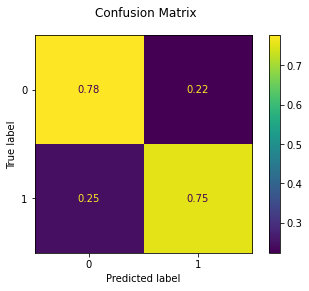

(0.9997994987468671, 0.7665664160401002)

In [49]:
knn_resultD2 = KNeighborsClassifier(n_neighbors=n_optD2, weights='distance', p=2)
fit_evaluate(knn_resultD2, X1_train, y_train, X1_test, y_test)

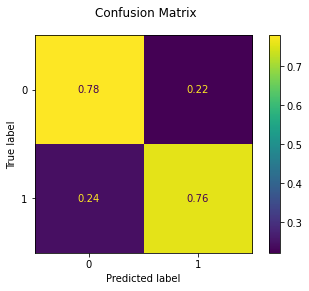

(0.7756015037593985, 0.7692731829573934)

In [50]:
knn_resultU1 = KNeighborsClassifier(n_neighbors=n_optU1, weights='uniform', p=1)
fit_evaluate(knn_resultU1, X1_train, y_train, X1_test, y_test)

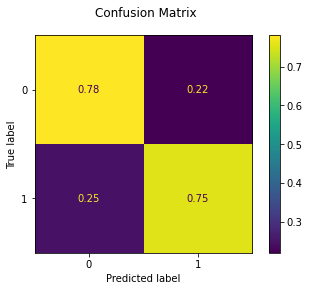

(0.7751127819548872, 0.7685714285714286)

In [51]:
knn_resultU2 = KNeighborsClassifier(n_neighbors=n_optU2, weights='uniform', p=2)
fit_evaluate(knn_resultU2, X1_train, y_train, X1_test, y_test)

**Выводы**:
- В качестве итоговой модели выберем KNN (uniform, k_neighbors=50) и Logistic Regression (Linear, L1, C=0.5).

### 5. Формирование Submission

 Делаем предсказание по тестовой выборке. Формируем файл submission.csv и отправляем на Kaggle.
 Пока максимальная точность составляет `Score: 0.79752 , Private score: 0.79286`.
 
 https://www.kaggle.com/competitions/tabular-playground-series-apr-2021/submissions?sortBy=date&page=1&pageSize=100
 
 В Leaderbord данные не отображаются, т.к. время соревнования прошло (скриншот прикрепить не удалось).

In [54]:
dataset_test = prepare_dataset(data_test)
dataset_test = update_dataset(dataset_test)
dataset_test.head()

will drop following columns: ['Name', 'Cabin'] .


,PassengerId,Pclass,Age,SibSp,Parch,Fare,Sex,Embarked,Ticket,Family,Ticket_code
0,100000,3,19.0,0,0,63.01,0,0,24745,0,0
1,100001,3,53.0,0,0,5.81,1,0,13264,0,0
2,100002,1,19.0,0,0,38.91,1,1,25990,0,0
3,100003,2,25.0,0,0,12.93,0,0,314011,0,0
4,100004,1,17.0,0,2,26.89,1,1,26203,2,0


In [55]:
print("#\tColumn Name \tNull, %")
print("---\t---   \t\t---")
i = 1
for col in dataset_test.columns:
    null_percent = dataset_test.loc[pd.isna(dataset_test[col])][col].shape[0] / dataset_test[col].shape[0] * 100
    print(f"{i}\t{col.ljust(15)}\t{null_percent}%")
    i += 1

#	Column Name 	Null, %
---	---   		---
1	PassengerId    	0.0%
2	Pclass         	0.0%
3	Age            	0.0%
4	SibSp          	0.0%
5	Parch          	0.0%
6	Fare           	0.0%
7	Sex            	0.0%
8	Embarked       	0.0%
9	Ticket         	0.0%
10	Family         	0.0%
11	Ticket_code    	0.0%


In [56]:
X_test = dataset_test[features].copy().to_numpy()
X1_test = scaler.fit_transform(X_test)

In [57]:
model_result = lr_result
# model_result = knn_resultU1
# model_result = knn_resultU2
predictions = model_result.predict(X1_test)
predictions

array([0, 1, 1, ..., 0, 1, 1])

In [58]:
# submisstion_data = dataset_test.copy()
submisstion_data = dataset_test[features + ['PassengerId']].copy()
submisstion_data['Survived'] = predictions
submisstion_data.drop(columns=features, inplace=True)
submisstion_data = submisstion_data.set_index('PassengerId')


# test_col_to_drop = ['SibSp', 'Parch', 'Ticket', 'Ticket_code']


submisstion_data

,Survived
PassengerId,
100000,0
100001,1
100002,1
100003,0
100004,1
...,...
199995,1
199996,0
199997,0


In [59]:
# submisstion_data.to_csv('submission.csv')
submisstion_data.to_csv('submission.csv')

![Image of Yaktocat](Kaggle_screenshot.png)